In [8]:
# --- Imports ---
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from datetime import datetime

In [10]:
import yfinance as yf
import pandas as pd

# --- 1. Data Extraction ---
start_date = "2015-07-01"
end_date = "2025-07-31"
assets = ["TSLA", "BND", "SPY"]

# Download full dataset
raw_data = yf.download(assets, start=start_date, end=end_date, progress=False)

# If Adjusted Close exists, use it; otherwise fallback to Close
if 'Adj Close' in raw_data.columns.get_level_values(0):
    data = raw_data['Adj Close']
else:
    print("⚠️ 'Adj Close' not found. Using 'Close' instead.")
    data = raw_data['Close']

# Ensure we only keep the assets we requested
data = data[assets]

print(data.head())


⚠️ 'Adj Close' not found. Using 'Close' instead.
Ticker           TSLA        BND         SPY
Date                                        
2015-07-01  17.943333  60.816727  174.917145
2015-07-02  18.667999  60.967117  174.756927
2015-07-06  18.648001  61.177597  174.259598
2015-07-07  17.858667  61.237675  175.355423
2015-07-08  16.997334  61.410629  172.413452


/tmp/ipython-input-3207394287.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(assets, start=start_date, end=end_date, progress=False)


In [11]:
# --- 2. Data Cleaning ---
# Check missing values
print("Missing values per asset:\n", data.isnull().sum())

Missing values per asset:
 Ticker
TSLA    0
BND     0
SPY     0
dtype: int64


In [12]:

# Forward fill missing data
data.ffill(inplace=True)

In [13]:
# Check data types
print("\nData Types:\n", data.dtypes)


Data Types:
 Ticker
TSLA    float64
BND     float64
SPY     float64
dtype: object


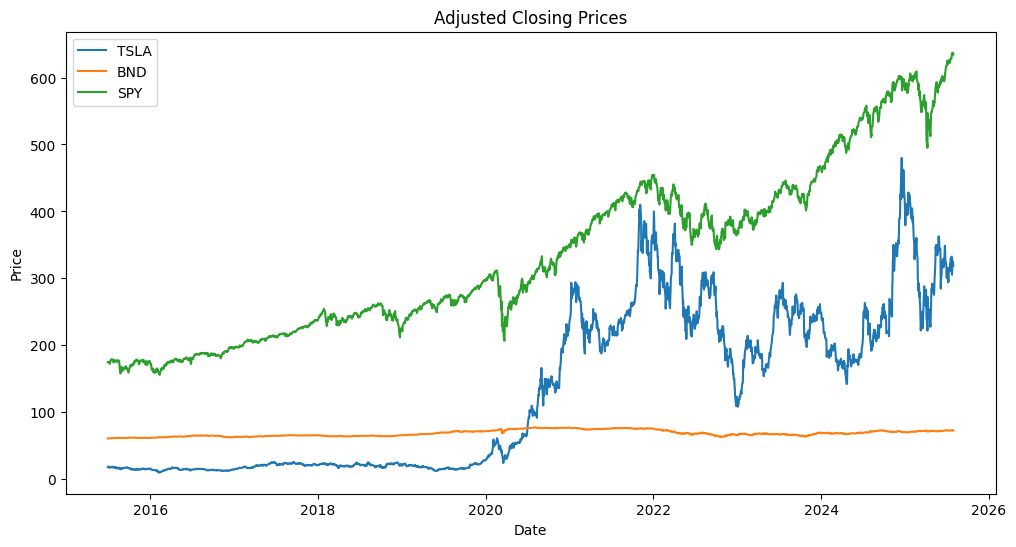

In [14]:
# --- 3. Exploratory Data Analysis ---
# Plot closing prices
plt.figure(figsize=(12,6))
for asset in assets:
    plt.plot(data.index, data[asset], label=asset)
plt.title("Adjusted Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [15]:

# Daily returns
returns = data.pct_change().dropna()

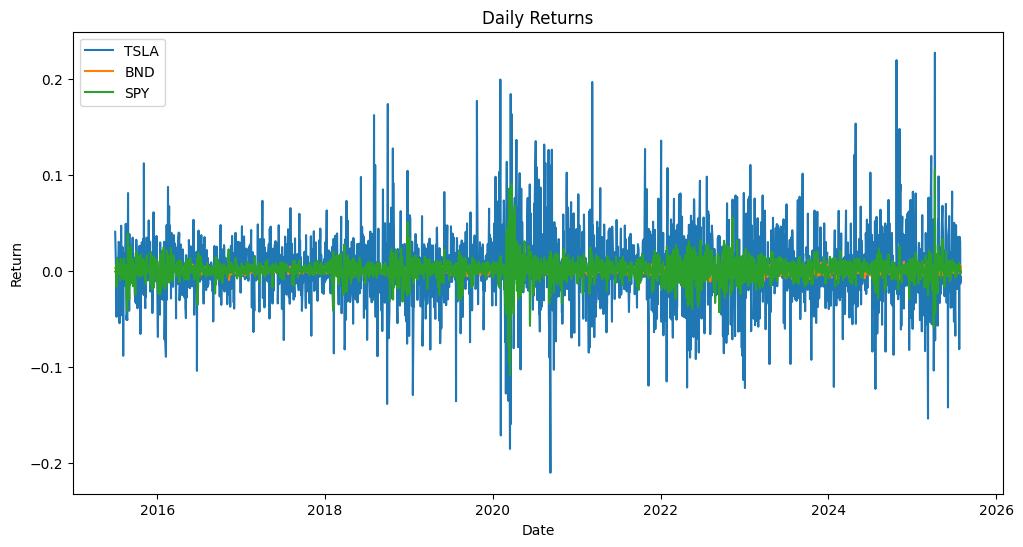

In [16]:
# Plot daily returns
plt.figure(figsize=(12,6))
for asset in assets:
    plt.plot(returns.index, returns[asset], label=asset)
plt.title("Daily Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.show()

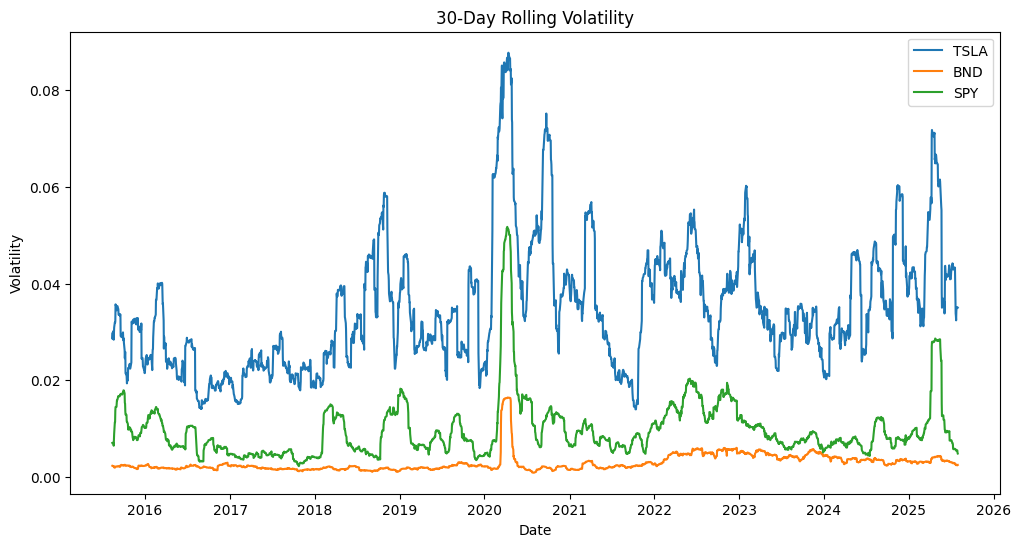

In [17]:
# Volatility (Rolling Std Dev over 30 days)
volatility = returns.rolling(window=30).std()

plt.figure(figsize=(12,6))
for asset in assets:
    plt.plot(volatility.index, volatility[asset], label=asset)
plt.title("30-Day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

In [18]:
# --- 4. Stationarity Check (ADF Test) ---
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations Used']
    for value, label in zip(result, labels):
        print(f'{label}: {value}')
    if result[1] <= 0.05:
        print("✅ Stationary")
    else:
        print("❌ Non-stationary")
    print()

for asset in assets:
    adf_test(data[asset], title=asset)

Augmented Dickey-Fuller Test: TSLA
ADF Statistic: -1.4188720053968238
p-value: 0.5731959514207239
# Lags Used: 27
# Observations Used: 2507
❌ Non-stationary

Augmented Dickey-Fuller Test: BND
ADF Statistic: -1.5362493971401874
p-value: 0.5155091959907326
# Lags Used: 13
# Observations Used: 2521
❌ Non-stationary

Augmented Dickey-Fuller Test: SPY
ADF Statistic: 0.6908119967611787
p-value: 0.989652712338845
# Lags Used: 9
# Observations Used: 2525
❌ Non-stationary



In [19]:
# --- 5. Risk Metrics ---
def sharpe_ratio(returns, risk_free_rate=0.0):
    mean_return = returns.mean()
    std_return = returns.std()
    return (mean_return - risk_free_rate) / std_return

def value_at_risk(returns, confidence_level=0.05):
    return returns.quantile(confidence_level)

print("\n--- Risk Metrics ---")
for asset in assets:
    print(f"{asset} Sharpe Ratio: {sharpe_ratio(returns[asset]):.4f}")
    print(f"{asset} 5% VaR: {value_at_risk(returns[asset]):.4f}")
    print()


--- Risk Metrics ---
TSLA Sharpe Ratio: 0.0490
TSLA 5% VaR: -0.0547

BND Sharpe Ratio: 0.0225
BND 5% VaR: -0.0049

SPY Sharpe Ratio: 0.0500
SPY 5% VaR: -0.0172



In [20]:
# --- Save processed data ---
data.to_csv("processed_prices.csv")
returns.to_csv("daily_returns.csv")
print("✅ Data saved: processed_prices.csv & daily_returns.csv")

✅ Data saved: processed_prices.csv & daily_returns.csv
